In [ ]:
# 라이브러리 로드
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.autograd import Variable 
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 라이브러리 로드
# 부하량 예측
!pip install -q shap
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import xgboost
from __future__ import print_function
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import scipy as sp
import scipy.cluster
import glob
import random
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

Solar Power Generation Predict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/powergen.csv',engine='python',encoding='CP949'))
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace = True)
xy = df
xy.dtypes
xy.head()

,month,day,week,time,rain,prevrain,wind,prevwind,ilsa,previlsa,prevpower,power
date,,,,,,,,,,,,
2016-01-01 00:00:00,1,1,5,0,0.0,0.0,0.6,0.6,0.0,0.0,0,0
2016-01-01 01:00:00,1,1,5,1,0.0,0.0,0.7,0.6,0.0,0.0,0,0
2016-01-01 02:00:00,1,1,5,2,0.0,0.0,0.9,0.7,0.0,0.0,0,0
2016-01-01 03:00:00,1,1,5,3,0.0,0.0,0.7,0.9,0.0,0.0,0,0
2016-01-01 04:00:00,1,1,5,4,0.0,0.0,0.2,0.7,0.0,0.0,0,0


In [ ]:
x = df[['day', 'time', 'rain', 'prevrain', 'wind', 'prevwind', 'ilsa', 'previlsa', 'prevpower']]
y = xy.iloc[:, -1]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x) # fit으로 평균과 표준편차를 계산하여 transform으로 평균0 분산 1이 되도록 만들기 (5112행 4열 )
y_tensor = torch.FloatTensor(y).unsqueeze(1) # floattensor로 텐서를 만들고 unsqueeze 1인 차원 생성 shape->(5112.1)
y_mm = mm.fit_transform(y_tensor) #0~1로 정규화

# Train Data 80%
x_train = x_ss[:3500, :]
y_train = y_mm[:3500, :]
# Test Data 20%
x_test = x_ss[3500:, :]
y_test = y_mm[3500:, :] 
# # shuffle the training set (but do not shuffle the test set)

# np.random.shuffle(x_train)
# np.random.shuffle(y_train)

In [ ]:
X_train_tensors = Variable(torch.Tensor(x_train))
X_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))
#3차원 tensor
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [ ]:
X_train_tensors.shape

torch.Size([3500, 9])

In [ ]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1 #128
    self.fc = nn.Linear(32, num_classes) #fully connected last layer #128

    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
   
    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output
   
    return out 

In [ ]:
LSTM = torch.nn.LSTM(4, 2, 1)

In [ ]:
num_epochs = 20000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 9 #number of features
hidden_size = 32 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

RMSE = 0.06389397050826397


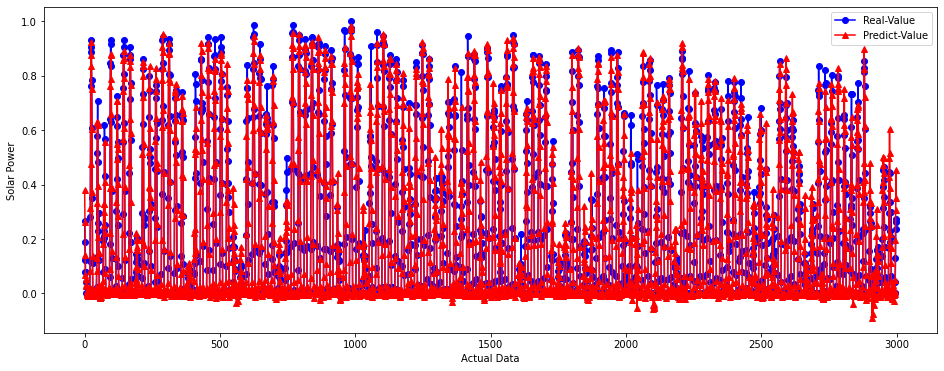

In [ ]:
df_X_ss = x_ss
df_y_mm = y_mm

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()
fig = plt.figure(figsize = (16,6)) # 사이즈 지정
graph = fig.add_subplot(1,1,1) # 그래프 추가 (행, 열, 위치)

print('RMSE =',mean_squared_error(data_predict,dataY_plot)**0.5)
graph.plot(dataY_plot[1500:4500],marker = 'o',color = 'blue',label="Real-Value") # 실제값 그래프 플롯
graph.plot(data_predict[1500:4500],marker = '^',color ='red',label = "Predict-Value") # 예측값 그래프 플롯

# plt.axvline(x=3500, c='r', linestyle='--') #size of the training set
plt.xlabel("Actual Data",size = 10)
plt.ylabel("Solar Power",size = 10) 
plt.legend(loc='best') # 데이터 범례 표시

# fig = plt.figure()
# fig = plt.figure(figsize = (100,6))
# plt.plot(dataY_plot)
# plt.plot(data_predict)
# plt.axvline(x=3500, c='r', linestyle='--') #size of the training set
# plt.xlabel('Hour')
# plt.ylabel('Electricity load (*1e5)')
# plt.show()

In [ ]:
# e = shap.DeepExplainer(lstm1, X_train_tensors_final )
# shap_values_lstm = e.shap_values(X_test_tensors_final)
# print(X_train_tensors_final.shape)
# print(X_test_tensors_final.shape)

In [ ]:

# shap_val = np.array(shap_values_lstm)
# test_final = np.array(X_train_tensors_final)
# # shap_val = np.reshape(shap_val,(int(shap_val.shape[0]), int(shap_val.shape[2])))
# # print(shap_val.shape)
# # # print(shap_val)
# # shap_abs = np.absolute(shap_val)
# # sum_0 = np.mean(shap_abs,axis=0)
# # shap_abs = np.reshape(shap_abs,(int(shap_abs.shape[0]),int(shap_abs.shape[2])))
# # print(shap_abs.shape)
# # shap_plot = pd.DataFrame(shap_abs, columns=["day", "time", "rain", "prevrain", "wind", "prevwind", "ilsa", "previlsa", "prevpower"])
# shap.initjs()
# # print(X_train_tensors_final[-5:])
# # # print(shap_values_lstm[-5:])

# # X_train_array = X_train_tensors_final.numpy()
# # print(test_final.size())
# # print(shap_val.size())
# shap.summary_plot(shap_val, X_train_tensors_final, plot_type='bar')
# shap.summary_plot(shap_values_lstm[1611], X_train_tensors_final[1611], plot_type='bar')

In [ ]:
# X_train_tensors = Variable(torch.Tensor(x_train))
# X_test_tensors = Variable(torch.Tensor(x_test))

# y_train_tensors = Variable(torch.Tensor(y_train))
# y_test_tensors = Variable(torch.Tensor(y_test))
# #3차원 tensor
# X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
# X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

xai using treeshap

[02:02:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


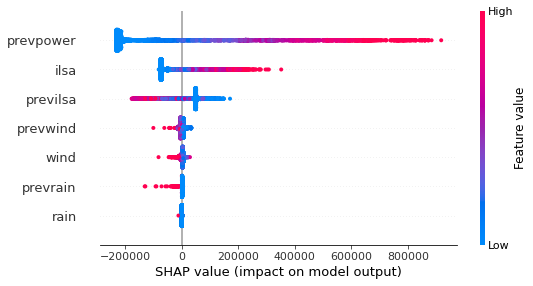

In [ ]:
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/powergen.csv',engine='python',encoding='CP949'))
check_additivity=False
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace = True)
xy = df

X = xy[['rain', 'prevrain', 'wind', 'prevwind', 'ilsa', 'previlsa', 'prevpower']]
y = xy[['power']]

# train size 80% test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
# train XGBoost model
model = xgboost.XGBRegressor(objective ='reg:linear')
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

plt.show()

Load Predict

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torch.autograd import Variable 
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.datasets import imdb

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/2016thdl_new.csv',engine='python',encoding='CP949'))
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace = True)
xy = df
xy.dtypes

In [ ]:
X = df[['month','day','week','time','temp','rh','di','prev_load']]
Y = df['load']

mm = MinMaxScaler()
ss = StandardScaler()

X_data = ss.fit_transform(X) # fit으로 평균과 표준편차를 계산하여 transform으로 평균0 분산 1이 되도록 만들기 (5832행 4열 )
y_tensor = torch.FloatTensor(Y).unsqueeze(1) # floattensor로 텐서를 만들고 unsqueeze 1인 차원 생성 shape->(5832.1)
Y_data = mm.fit_transform(y_tensor) #0~1로 정규화

X_data = np.array(X_data, dtype='float32')
Y_data = np.array(Y_data, dtype='float32')

list_daily_load = np.reshape(Y_data, (len(Y_data)))
list_daily_weather = np.reshape(X_data, (len(X_data),8,1))

In [ ]:
train_row = int(round(0.8 * list_daily_weather.shape[0]))
train_set_x = list_daily_weather[:train_row]
train_set_y = list_daily_load[:train_row]
X_train = train_set_x
Y_train = train_set_y
X_test = list_daily_weather[train_row:]
Y_test = list_daily_load[train_row:]

In [ ]:
# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM(48, input_dim = 1, return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(96, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(1, activation='linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")

# train the model
model.fit(X_train, Y_train, batch_size=100, epochs=50, validation_split=0.05, verbose=1)

Epoch 1/50
39/39 [==============================] - 6s 48ms/step - loss: 0.0376 - val_loss: 0.0213
Epoch 2/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0190 - val_loss: 0.0194
Epoch 3/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0127 - val_loss: 0.0064
Epoch 4/50
39/39 [==============================] - 1s 22ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 5/50
39/39 [==============================] - 1s 22ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 6/50
39/39 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 7/50
39/39 [==============================] - 1s 22ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 8/50
39/39 [==============================] - 1s 22ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 9/50
39/39 [==============================] - 1s 22ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 10/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 11/

In [ ]:
from sklearn.metrics import mean_squared_error
# evaluate the result
test_mse = model.evaluate(X_test, Y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(Y_test)))

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

print('RMSE =',mean_squared_error(predicted_values,Y_test)**0.5)

32/32 [==============================] - 0s 3ms/step - loss: 0.0013

The mean squared error (MSE) on the test data set is 0.001 over 1022 test samples.
RMSE = 0.036640626148882686


<Figure size 432x288 with 0 Axes>

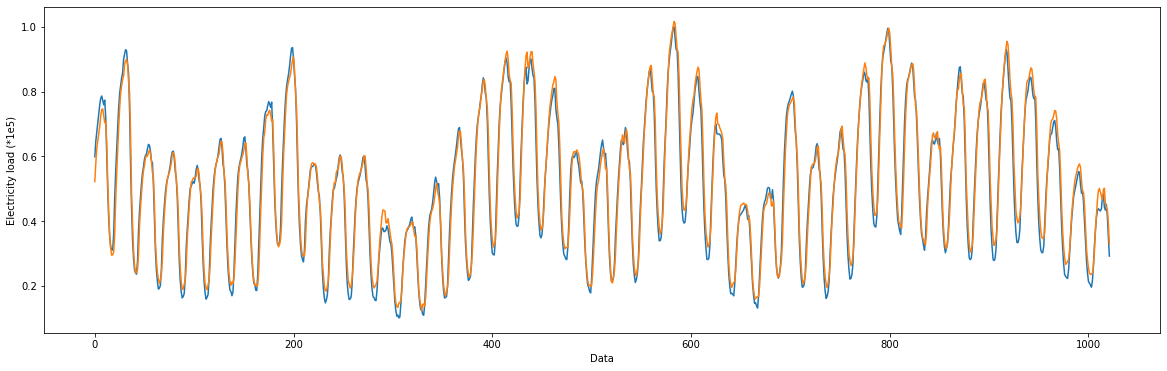

In [ ]:
# plot the results
fig = plt.figure()
fig = plt.figure(figsize = (20,6))
plt.plot(Y_test)
plt.plot(predicted_values)
# plt.axvline(x=4090, c='r', linestyle='--') #size of the training set
plt.xlabel('Data')
plt.ylabel('Electricity load (*1e5)')
plt.show()
fig.savefig('output_load_forecasting.jpg', bbox_inches='tight')

xai using TreeSHAP

[02:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


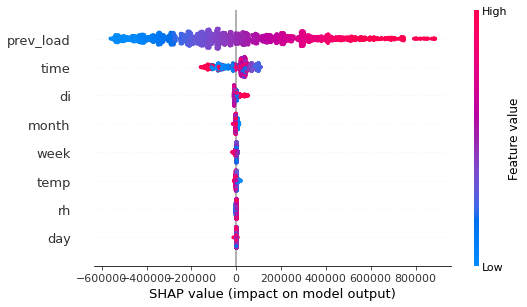

In [ ]:
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/2016thdl_new.csv',engine='python',encoding='CP949'))
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace = True)
xy = df
X = df[['month','day','week','time','temp','rh','di','prev_load']]
y = xy[['load']]

# train size 80% test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
# print(X_train[:10])
# train XGBoost model
model = xgboost.XGBRegressor(objective ='reg:linear')
model.fit(X_train, y_train)
preds = model.predict(X_test)

# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

plt.show()